In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import keras
from keras.models import *
from keras.layers import *
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
from keras import backend as K
K.set_session(session)

/hdd/home/peter0749/virtualenv/tf_keras/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/hdd/home/peter0749/virtualenv/tf_keras/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
DATASET_ROOT = '/hdd/dataset/tbrain/'
TRAIN_PATH = os.path.join(DATASET_ROOT, 'taetfp_utf8.csv')
TS_IN=30
TS_OUT=5

In [3]:
train_csv = pd.read_csv(TRAIN_PATH)
train_csv.sort_values(by=['日期'], ascending=True, inplace=True)
train_csv.head(n=10)

,代碼,日期,中文簡稱,開盤價(元),最高價(元),最低價(元),收盤價(元),成交張數(張)
0,50,20130102,元大台灣50,46.57,47.13,46.49,46.92,"16,487"
11574,59,20130102,富邦金融,24.65,24.65,24.65,24.65,2
14146,6203,20130102,元大MSCI台灣,22.61,22.61,22.56,22.56,28
16718,6208,20130102,富邦台50,27.00,27.33,26.99,27.21,79
7716,56,20130102,元大高股息,18.45,18.63,18.45,18.55,"1,623"
2572,52,20130102,富邦科技,27.45,27.85,27.45,27.81,26
15432,6204,20130102,永豐臺灣加權,33.61,33.95,33.53,33.86,"1,574"
9002,57,20130102,富邦摩台,30.35,30.69,30.35,30.69,69
1286,51,20130102,元大中型100,22.36,22.66,22.36,22.65,277
10288,58,20130102,富邦發達,32.45,32.45,32.12,32.12,2


In [4]:
codes = list(sorted(set(train_csv['代碼'])))
fields = ['開盤價(元)', '最高價(元)', '最低價(元)', '收盤價(元)', '成交張數(張)']

In [5]:
split_train = []
for code in codes:
    row = train_csv.loc[train_csv['代碼']==code][fields]
    row = row.applymap(lambda x: float(x.replace(',','')) if type(x)==str else x)
    split_train.append(np.array(row))

In [6]:
len(codes), len(split_train)

(18, 18)

In [7]:
split_train[0]

array([[   46.57,    47.13,    46.49,    46.92, 16487.  ],
       [   47.35,    47.48,    47.13,    47.31, 29020.  ],
       [   47.31,    47.31,    46.92,    47.  ,  9837.  ],
       ...,
       [   82.25,    82.35,    81.8 ,    82.1 ,  4099.  ],
       [   82.65,    83.05,    82.65,    82.85,  4994.  ],
       [   82.85,    83.05,    82.75,    82.95,   878.  ]])

In [8]:
for s in split_train:
    print(len(s))

1286
1286
1286
1286
1286
1286
1286
1286
1286
1286
248
218
153
124
1286
1286
1286
1286


In [9]:
from keras.regularizers import *

# custom R2-score metrics for keras backend
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

def make_model(ts_in=60, ts_out=5, n_field=5, n_encode=128, n_decode=128, reg_a=0.1):
    input_ = Input(shape=(ts_in, n_field))
    lstm_1 = CuDNNLSTM(n_encode, return_sequences=False, recurrent_regularizer=l2(reg_a)) (input_)
    rep_vec_2 = RepeatVector(ts_out) (lstm_1)
    lstm_3 = CuDNNLSTM(n_decode, return_sequences=True, recurrent_regularizer=l2(reg_a)) (rep_vec_2)
    lstm_4 = CuDNNLSTM(n_decode, return_sequences=True, recurrent_regularizer=l2(reg_a)) (lstm_3)
    fc_4 = TimeDistributed(Dense(1, kernel_regularizer=l2(reg_a))) (lstm_4)
    return Model([input_], [fc_4])
make_model(ts_in=TS_IN, ts_out=TS_OUT).summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30, 5)             0         
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 128)               69120     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 5, 128)            0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 5, 128)            132096    
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 5, 128)            132096    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 1)              129       
Total params: 333,441
Trainable params: 333,441
Non-trainable params: 0
_________________________________________________________________


In [10]:
def make_seq(seq, ts_in=60, ts_out=5):
    Xs = []
    Ys = []
    total_l = ts_in + ts_out
    for i in range(0, len(seq)-total_l+1):
        Xs.append(seq[i:i+ts_in])
        Ys.append(seq[i+ts_in:i+total_l, 3:4])
    return np.array(Xs), np.array(Ys)

In [11]:
train_18 = []
for seq in split_train:
    Xs, Ys = make_seq(seq, ts_in=TS_IN, ts_out=TS_OUT)
    train_18.append([Xs, Ys])

In [12]:
def vis(history, title='no title', dpi=80):
    fig, ax = plt.subplots(1, 2, dpi=80)
    ax[0].set_title(title+' loss plot')
    ax[1].set_title(title+' r2 plot')
    ax[0].set_xlabel('epoch')
    ax[1].set_xlabel('epoch')
    ax[0].set_ylabel('mse')
    ax[1].set_ylabel('r2')
    ax[0].set_ylim(0, 180)
    ax[1].set_ylim(-2, 1)
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].legend(['train','valid'], loc='upper right')
    ax[1].plot(history.history['r2_keras'])
    ax[1].plot(history.history['val_r2_keras'])
    ax[1].legend(['train','valid'], loc='lower right')
    plt.tight_layout()
    plt.show()

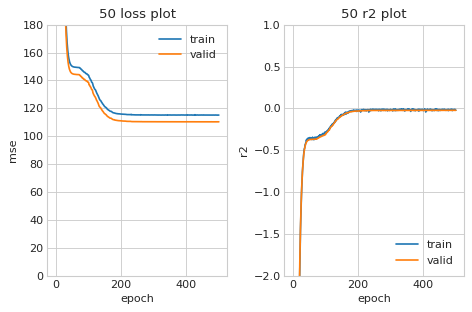

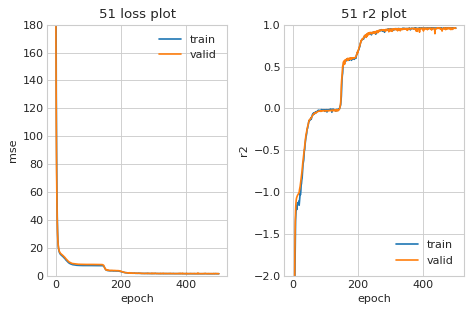

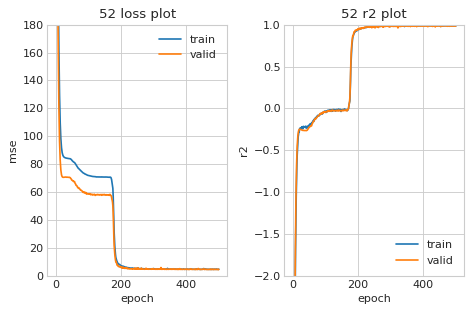

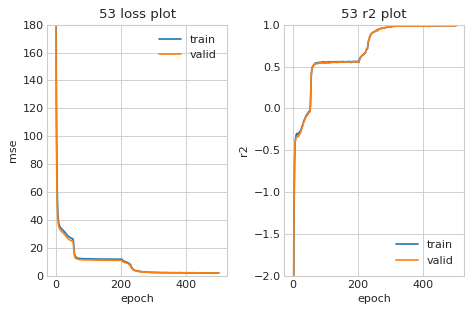

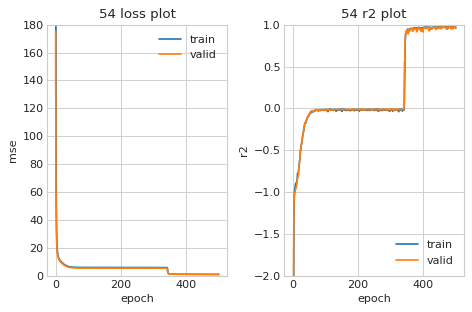

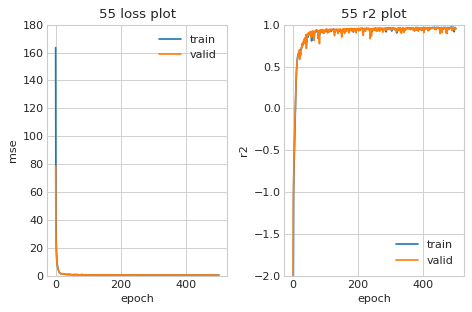

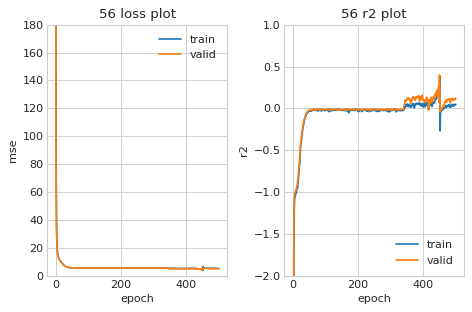

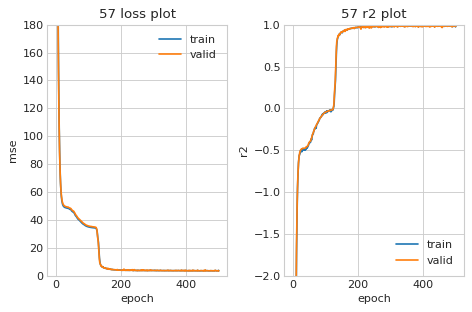

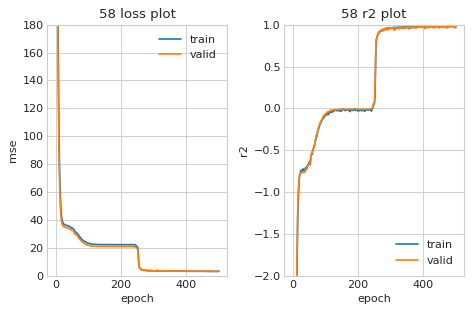

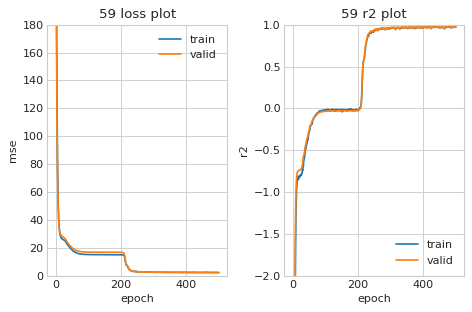

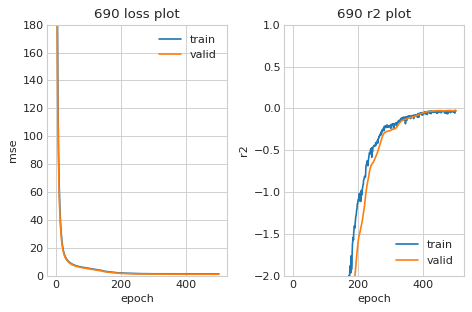

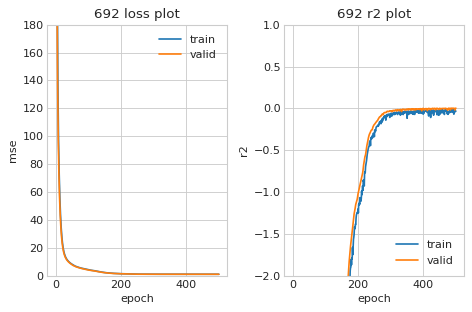

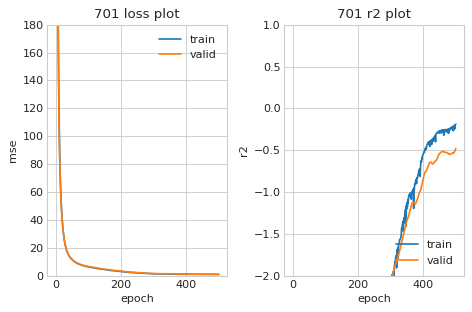

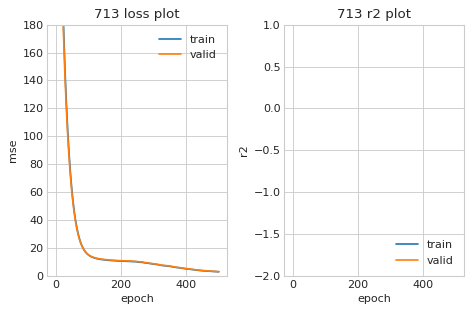

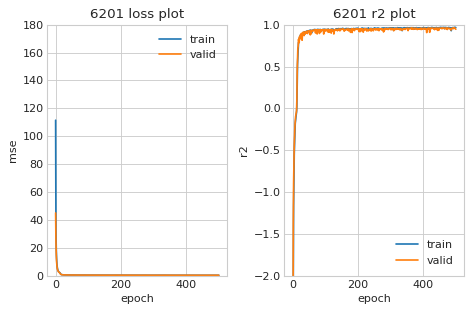

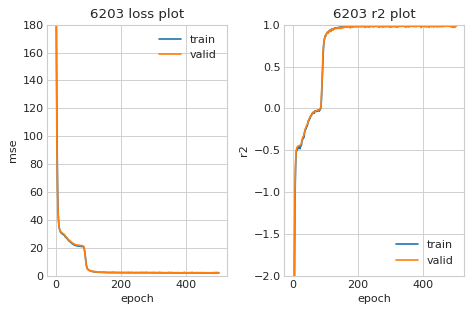

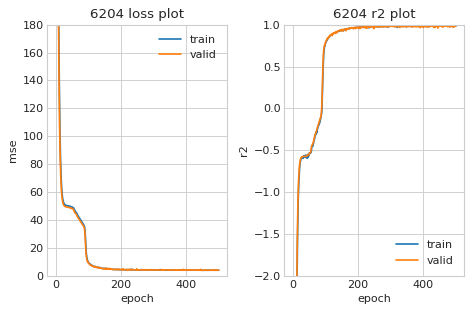

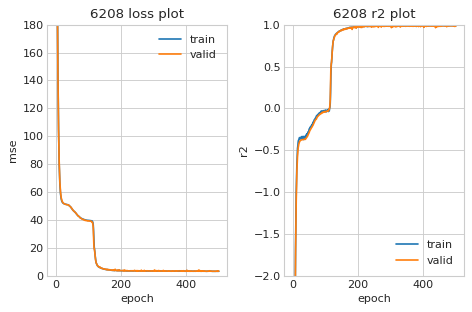

In [13]:
from keras.callbacks import *
from sklearn.model_selection import train_test_split
BATCH_SIZE = 64
EPOCH = 500
for model_n, (X, Y) in enumerate(train_18):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
    prefix = str(codes[model_n])
    model = make_model(ts_in=TS_IN, ts_out=TS_OUT)
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[r2_keras])
    history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test) , batch_size=BATCH_SIZE, epochs=EPOCH, callbacks=[TensorBoard(log_dir=prefix+'logs')], shuffle=True, verbose=0)
    vis(history, title=prefix, dpi=130)
    model.save(prefix+'_model.h5')
    K.clear_session()

![](https://tbrain.trendmicro.com.tw/Content/img/18etf.png)